# Lab 4 - AI / ML leveraging Data Lake 

After handing on this lab, you will learn how to get started using Amazon Forecast by Jupyter (Python) notebook.

## What Is Amazon Forecast?

<img src="https://d2908q01vomqb2.cloudfront.net/77de68daecd823babbb58edb1c8e14d7106e83bb/2019/09/04/Amazon-Forecast-1.png">

Amazon Forecast is the new tool for time series automated forecasting. It uses machine learning to combine time series data with additional variables to build forecasts,but requires no machine learning experience to get started. By providing Amazon Forecast with historical time-series data, you can predict future points in the series. 

## How it works

<img src="https://raw.githubusercontent.com/aws-samples/amazon-forecast-samples/master/notebooks/BlogImages/amazon_forecast.png">

## Steps:
The overall process for using Amazon Forecast is the following:<br>
  
 - Prepare Data
 - Create a Dataset Group, this is the large box that isolates models and the data they are trained on from each other.
 - Create a Dataset, in Forecast there are 3 types of dataset, Target Time Series, Related Time Series, and Item Metadata. The Target Time Series is required, the others provide additional context with certain algorithms.
 - Import data, this moves the information from S3 into a storage volume where the data can be used for training and validation.
 - Train a model, Forecast automates this process for you but you can also select particular algorithms, and you can provide your own hyper parameters or use Hyper Parameter Optimization(HPO) to determine the most performant values for you.
 - Deploy a Predictor, here you are deploying your model so you can use it to generate a forecast.
 - Query the Forecast, given a request bounded by time for an item, return the forecast for it. Once you have this you can evaluate its performance or use it to guide your decisions about the future.

<img src="https://raw.githubusercontent.com/aws-samples/amazon-forecast-samples/master/notebooks/BlogImages/types_data.png">

## Setup

In [113]:
import boto3
import datetime
from time import sleep
import subprocess
import pandas as pd
import json
import time
import sys
from datetime import datetime
from dateutil.parser import parse

In [114]:
!{sys.executable} -m pip install PyAthena

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [115]:
session = boto3.Session(region_name='us-east-1') 
forecast = session.client(service_name='forecast') 
forecastquery = session.client(service_name='forecastquery')

## Preparing your Data

In Amazon Forecast , a dataset is a collection of file(s) which contain data that is relevant for a forecasting task. A dataset must conform to a schema provided by Amazon Forecast. 

### Data Type

Amazon forecast can import data from Amazon S3. We first explore the data locally to see the fields

In [116]:
sql = f""" 
SELECT date_trunc('hour',date_parse(replace(tpep_pickup_datetime,'"'),'%Y-%m-%d %H:%i:%s')) AS date ,Count(*) AS Taxi_PickUp
    FROM sampledb.yellow
    GROUP BY  1
"""
from pyathena import connect
import pandas as pd
conn = connect(s3_staging_dir='s3://aws-athena-query-results-268522462432-us-east-1/Unsaved/2019/11/05/',region_name='us-east-1')

df = pd.read_sql(sql, conn)
df['Taxi_PickUp'] = df['Taxi_PickUp'].astype(float)
df = df.sort_values(by="date")
print()
df.head()

date  Taxi_PickUp
6386 2015-01-01 00:00:00      28312.0
5407 2015-01-01 01:00:00      31707.0
652  2015-01-01 02:00:00      28068.0
4364 2015-01-01 03:00:00      24288.0
807  2015-01-01 04:00:00      17081.0

Notice in the output above there are 3 columns of data:
 - The Timestamp
 - A Value
 - An Item

These are the 3 key required pieces of information to generate a forecast with Amazon Forecast. More can be added but these 3 must always remain present.<br>
The dataset happens to span January 01, 2015 to Deceber 31, 2015. For our testing we would like to keep the last month of information in a differennt CSV. We are also going to save January to November to a different CSV as well.

In [119]:
# Select January to November for one dataframe.
jan_to_oct = df[df['date'] <= '2015-10-31']

# Select the month of December for another dataframe.
remaining_df = df[(df['date'] >= '2015-10-31')&(df['date'] <= '2015-12-01')]

In [120]:
jan_to_oct['item_id'] = 'Taxi'
jan_to_oct.columns = [''] * len(jan_to_oct.columns)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Now export them to CSV files and place them into your data folder.

In [122]:
jan_to_oct.to_csv("item-demand-time-train.csv", header=False, index=False)
remaining_df.to_csv("item-demand-time-validation.csv", header=False, index=False)

At this time the data is ready to be sent to S3 where Forecast will use it later. Update the bucketname in the cell below to reflect the value you obtained from our output earlier when you finished the CloudFormation step.

In [123]:
s3 = session.client('s3')
accountId = boto3.client('sts').get_caller_identity().get('Account')
bucketName = "ecv-tutorial-preparation"# Rember to change this.
key="Forecast/item-demand-time-train.csv"
s3.upload_file(Filename="item-demand-time-train.csv", Bucket=bucketName, Key=key)

# Creating the Dataset Group and Dataset 

In Amazon Forecast , a dataset is a collection of file(s) which contain data that is relevant for a forecasting task.<br> A dataset must conform to a schema provided by Amazon Forecast.
More details about Domain and dataset type can be found on the documentation . For this lab, we are using CUSTOM domain with 3 required attributes timestamp, target_value and item_id.

In [124]:
DATASET_FREQUENCY = "H" 
TIMESTAMP_FORMAT = "yyyy-MM-dd hh:mm:ss"

project = 'Taxi_demand_forecastdemo'
datasetName= project+'_ds'
datasetGroupName= project +'_dsg'
s3DataPath = "s3://"+bucketName+"/"+key

## Schema Definition 

In [129]:
# Specify the schema of your dataset here. Make sure the order of columns matches the raw data files.
schema ={
   "Attributes":[
      {
         "AttributeName":"timestamp",
         "AttributeType":"timestamp"
      },
      {
         "AttributeName":"target_value",
         "AttributeType":"float"
      },
      {
         "AttributeName":"item_id",
         "AttributeType":"string"
      }
   ]
}


## Create the Dataset

In [130]:
response=forecast.create_dataset(
                    Domain="CUSTOM",
                    DatasetType='TARGET_TIME_SERIES',
                    DatasetName=datasetName,
                    DataFrequency=DATASET_FREQUENCY, 
                    Schema = schema
)

In [131]:
datasetArn = response['DatasetArn']
forecast.describe_dataset(DatasetArn=datasetArn)

{'DatasetArn': 'arn:aws:forecast:us-east-1:268522462432:dataset/Taxi_demand_forecastdemo_ds',
 'DatasetName': 'Taxi_demand_forecastdemo_ds',
 'Domain': 'CUSTOM',
 'DatasetType': 'TARGET_TIME_SERIES',
 'DataFrequency': 'H',
 'Schema': {'Attributes': [{'AttributeName': 'timestamp',
    'AttributeType': 'timestamp'},
   {'AttributeName': 'target_value', 'AttributeType': 'float'},
   {'AttributeName': 'item_id', 'AttributeType': 'string'}]},
 'EncryptionConfig': {},
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2019, 12, 25, 9, 22, 45, 328000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2019, 12, 25, 9, 22, 45, 328000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': 'b4f9cdb9-057a-486e-894b-7aaf7de9b880',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Wed, 25 Dec 2019 09:22:47 GMT',
   'x-amzn-requestid': 'b4f9cdb9-057a-486e-894b-7aaf7de9b880',
   'content-length': '515',
   'connection': 'keep-alive'},

## Create the Dataset Group

In [132]:
create_dataset_group_response = forecast.create_dataset_group(DatasetGroupName=datasetGroupName,
                                                              Domain="CUSTOM",
                                                              DatasetArns= [datasetArn]
                                                             )
datasetGroupArn = create_dataset_group_response['DatasetGroupArn']
forecast.describe_dataset_group(DatasetGroupArn=datasetGroupArn)

{'DatasetGroupName': 'Taxi_demand_forecastdemo_dsg',
 'DatasetGroupArn': 'arn:aws:forecast:us-east-1:268522462432:dataset-group/Taxi_demand_forecastdemo_dsg',
 'DatasetArns': ['arn:aws:forecast:us-east-1:268522462432:dataset/Taxi_demand_forecastdemo_ds'],
 'Domain': 'CUSTOM',
 'Status': 'ACTIVE',
 'CreationTime': datetime.datetime(2019, 12, 25, 9, 22, 51, 626000, tzinfo=tzlocal()),
 'LastModificationTime': datetime.datetime(2019, 12, 25, 9, 22, 51, 626000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': '20dfe49d-eebc-4aae-bee3-9c056706105b',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Wed, 25 Dec 2019 09:22:51 GMT',
   'x-amzn-requestid': '20dfe49d-eebc-4aae-bee3-9c056706105b',
   'content-length': '356',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

## Add Dataset to Dataset Group

In [133]:
forecast.update_dataset_group(DatasetGroupArn=datasetGroupArn, DatasetArns=[datasetArn])

{'ResponseMetadata': {'RequestId': '250d7d22-0b97-4b8a-ae69-d4f1be02beae',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Wed, 25 Dec 2019 09:22:54 GMT',
   'x-amzn-requestid': '250d7d22-0b97-4b8a-ae69-d4f1be02beae',
   'content-length': '2',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

## Create IAM Role for Forecast

Like many AWS services, Forecast will need to assume an IAM role in order to interact with your S3 resources securely. The code below will create the role and it will be used later for accessing your data in S3.

In [139]:
iam = boto3.client("iam")

role_name = "ForecastRoleDemo"
assume_role_policy_document = {
    "Version": "2012-10-17",
    "Statement": [
        {
          "Effect": "Allow",
          "Principal": {
            "Service": "forecast.amazonaws.com"
          },
          "Action": "sts:AssumeRole"
        }
    ]
}

create_role_response = iam.create_role(
    RoleName = role_name,
    AssumeRolePolicyDocument = json.dumps(assume_role_policy_document)
)

# AmazonPersonalizeFullAccess provides access to any S3 bucket with a name that includes "personalize" or "Personalize" 
# if you would like to use a bucket with a different name, please consider creating and attaching a new policy
# that provides read access to your bucket or attaching the AmazonS3ReadOnlyAccess policy to the role
policy_arn = "arn:aws:iam::aws:policy/AmazonForecastFullAccess"
iam.attach_role_policy(
    RoleName = role_name,
    PolicyArn = policy_arn
)

# Now add S3 support
iam.attach_role_policy(
    PolicyArn='arn:aws:iam::aws:policy/AmazonS3FullAccess',
    RoleName=role_name
)
time.sleep(60) # wait for a minute to allow IAM role policy attachment to propagate

role_arn = create_role_response["Role"]["Arn"]
print(role_arn)

arn:aws:iam::268522462432:role/ForecastRoleDemo


## Create Data Import Job
Now that Forecast knows how to understand the CSV we are providing, the next step is to import the data from S3 into Amazon Forecaast.

In [140]:
datasetImportJobName = 'Demand_JOB_TARGET'
ds_import_job_response = forecast.create_dataset_import_job(DatasetImportJobName=datasetImportJobName,
                                                          DatasetArn=datasetArn,
                                                          DataSource= {
                                                              "S3Config" : {
                                                                 "Path":s3DataPath,
                                                                 "RoleArn": role_arn
                                                              } 
                                                          },
                                                          TimestampFormat=TIMESTAMP_FORMAT
                                                         )

In [141]:
ds_import_job_arn=ds_import_job_response['DatasetImportJobArn']
print(ds_import_job_arn)

arn:aws:forecast:us-east-1:268522462432:dataset-import-job/Taxi_demand_forecastdemo_ds/Demand_JOB_TARGET


Check the status of dataset, when the status change from <b>CREATE_IN_PROGRESS</b> to <b>ACTIVE</b>, we can continue to next steps. Depending on the data size. It can take 10 mins to be <b>ACTIVE</b>. This process will take 5 to 10 minutes.

In [142]:
while True:
    dataImportStatus = forecast.describe_dataset_import_job(DatasetImportJobArn=ds_import_job_arn)['Status']
    print(dataImportStatus)
    if dataImportStatus != 'ACTIVE' and dataImportStatus != 'CREATE_FAILED':
        sleep(30)
    else:
        break

CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
ACTIVE


In [143]:
forecast.describe_dataset_import_job(DatasetImportJobArn=ds_import_job_arn)

{'DatasetImportJobName': 'Demand_JOB_TARGET',
 'DatasetImportJobArn': 'arn:aws:forecast:us-east-1:268522462432:dataset-import-job/Taxi_demand_forecastdemo_ds/Demand_JOB_TARGET',
 'DatasetArn': 'arn:aws:forecast:us-east-1:268522462432:dataset/Taxi_demand_forecastdemo_ds',
 'TimestampFormat': 'yyyy-MM-dd hh:mm:ss',
 'DataSource': {'S3Config': {'Path': 's3://ecv-tutorial-preparation/Forecast/item-demand-time-train.csv',
   'RoleArn': 'arn:aws:iam::268522462432:role/ForecastRoleDemo'}},
 'FieldStatistics': {'item_id': {'Count': 7273,
   'CountDistinct': 1,
   'CountNull': 0},
  'target_value': {'Count': 7273,
   'CountDistinct': 6178,
   'CountNull': 0,
   'CountNan': 0,
   'Min': '14.0',
   'Max': '33159.0',
   'Avg': 16901.123332875017,
   'Stddev': 7475.23156679602},
  'timestamp': {'Count': 7273,
   'CountDistinct': 7273,
   'CountNull': 0,
   'Min': '2015-01-01T00:00:00Z',
   'Max': '2015-10-31T00:00:00Z'}},
 'DataSize': 0.000222034752368927,
 'Status': 'ACTIVE',
 'CreationTime': date

## Building Your Predictor

## Create a Predictor

In [21]:
predictorName= project +'_deepAr_algo'
forecastHorizon = 24
algorithmArn = 'arn:aws:forecast:::algorithm/Deep_AR_Plus'
create_predictor_response=forecast.create_predictor(PredictorName=predictorName, 
                                                  AlgorithmArn=algorithmArn,
                                                  ForecastHorizon=forecastHorizon,
                                                  PerformAutoML= False,
                                                  PerformHPO=False,
                                                  EvaluationParameters= {"NumberOfBacktestWindows": 1, 
                                                                         "BackTestWindowOffset": 24}, 
                                                  InputDataConfig= {"DatasetGroupArn": datasetGroupArn},
                                                  FeaturizationConfig= {"ForecastFrequency": "H", 
                                                                        "Featurizations": 
                                                                        [
                                                                          {"AttributeName": "target_value", 
                                                                           "FeaturizationPipeline": 
                                                                            [
                                                                              {"FeaturizationMethodName": "filling", 
                                                                               "FeaturizationMethodParameters": 
                                                                                {"frontfill": "none", 
                                                                                 "middlefill": "zero", 
                                                                                 "backfill": "zero"}
                                                                              }
                                                                            ]
                                                                          }
                                                                        ]
                                                                       }
                                                 )
predictorArn = create_predictor_response['PredictorArn']

NameError: name 'datasetGroupArn' is not defined

Check the status of the predictor. When the status change from CREATE_IN_PROGRESS to ACTIVE, we can continue to next steps. Depending on data size, model selection and hyper parameters，it can take 10 mins to more than one hour to be ACTIVE.

In [ ]:
while True:
    predictorStatus = forecast.describe_predictor(PredictorArn=predictorArn)['Status']
    print(predictorStatus)
    if predictorStatus != 'ACTIVE' and predictorStatus != 'CREATE_FAILED':
        sleep(30)
    else:
        break

CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PR

## Get Error Metrics

In [23]:
forecast.get_accuracy_metrics(PredictorArn=predictorArn)

{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/Deep_AR_Plus',
   'TestWindows': [{'EvaluationType': 'SUMMARY',
     'Metrics': {'RMSE': 1357.4429951639738,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.00945128690549833},
       {'Quantile': 0.5, 'LossValue': 0.02411202534871631},
       {'Quantile': 0.1, 'LossValue': 0.013567370356231312}]}},
    {'TestWindowStart': datetime.datetime(2015, 10, 30, 1, 0, tzinfo=tzlocal()),
     'TestWindowEnd': datetime.datetime(2015, 10, 31, 1, 0, tzinfo=tzlocal()),
     'ItemCount': 1,
     'EvaluationType': 'COMPUTED',
     'Metrics': {'RMSE': 1357.4429951639738,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.00945128690549833},
       {'Quantile': 0.5, 'LossValue': 0.02411202534871631},
       {'Quantile': 0.1, 'LossValue': 0.013567370356231312}]}}]}],
 'ResponseMetadata': {'RequestId': 'deaf4d22-258d-4138-8b26-8a98e8082ae8',
  'HTTPStatusCode': 200,
  'HTTPHeade

## Create Forecast

Now create a forecast using the model that was trained

In [24]:
forecastName= project+'demand_deepAR_algo_forecast'
create_forecast_response = forecast.create_forecast(ForecastName=forecastName,PredictorArn=predictorArn)
forecastArn = create_forecast_response['ForecastArn']

Check the status of the forecast process, when the status change from CREATE_IN_PROGRESS to ACTIVE, we can continue to next steps. Depending on data size, model selection and hyper parameters，it can take 10 mins to more than one hour to be ACTIVE.

In [26]:
while True:
    forecastStatus = forecast.describe_forecast(ForecastArn=forecast_arn)['Status']
    print(forecastStatus)
    if forecastStatus != 'ACTIVE' and forecastStatus != 'CREATE_FAILED':
        sleep(30)
    else:
        break


CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PROGRESS
CREATE_IN_PR

## Get Forecast

Once created, the forecast results are ready and you view them.

In [27]:
print(forecast_arn)
print()
forecastResponse = forecastquery.query_forecast(
    ForecastArn=forecastArn,
    Filters={"item_id":"Taxi"}
)
print(forecastResponse)

arn:aws:forecast:us-east-1:268522462432:forecast/Taxi_demand_forecastdemodemand_deepAR_algo_forecast

{'Forecast': {'Predictions': {'p10': [{'Timestamp': '2015-10-31T01:00:00', 'Value': 42118.52734375}, {'Timestamp': '2015-10-31T02:00:00', 'Value': 34318.48046875}, {'Timestamp': '2015-10-31T03:00:00', 'Value': 24728.193359375}, {'Timestamp': '2015-10-31T04:00:00', 'Value': 14409.048828125}, {'Timestamp': '2015-10-31T05:00:00', 'Value': 6709.5087890625}, {'Timestamp': '2015-10-31T06:00:00', 'Value': 8451.7744140625}, {'Timestamp': '2015-10-31T07:00:00', 'Value': 14585.2197265625}, {'Timestamp': '2015-10-31T08:00:00', 'Value': 21392.708984375}, {'Timestamp': '2015-10-31T09:00:00', 'Value': 29676.71875}, {'Timestamp': '2015-10-31T10:00:00', 'Value': 34456.94921875}, {'Timestamp': '2015-10-31T11:00:00', 'Value': 36561.23046875}, {'Timestamp': '2015-10-31T12:00:00', 'Value': 38843.453125}, {'Timestamp': '2015-10-31T13:00:00', 'Value': 38031.0}, {'Timestamp': '2015-10-31T14:00:00', 'Value': 

## Evaluating Your Forecast

let's pull down the predictions from this Predictor, and compare them to the actual observed values. This will let us know the impact of accuracy based on the Forecast.

## Select the Actual Results

Here, we select the First of November 2014 to plot.

In [144]:
actual_df = df[(df['date'] > '2015-10-31') & (df['date'] <= '2015-11-01')]
actual_df.head()

date  Taxi_PickUp
8062 2015-10-31 01:00:00      21394.0
8748 2015-10-31 02:00:00      19394.0
7887 2015-10-31 03:00:00      14944.0
7525 2015-10-31 04:00:00       9483.0
4817 2015-10-31 05:00:00       4404.0

## Plotting the Prediction

In [87]:
# Generate DF 
prediction_df = pd.DataFrame.from_dict(forecastResponse['Forecast']['Predictions']['p50'])

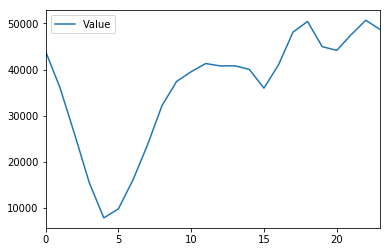

In [88]:
# Plot
prediction_df.plot()

## Comparing the Prediction to Actual Results

In [89]:
# We start by creating a dataframe to house our content, here source will be which dataframe it came from
results_df = pd.DataFrame(columns=['timestamp', 'value', 'source'])

In [90]:
for index, row in actual_df.iterrows():
    clean_timestamp = row['date']
    results_df = results_df.append({'timestamp' : clean_timestamp , 'value' : row['Taxi_PickUp'], 'source': 'actual'} , ignore_index=True)

In [91]:
for index, row in prediction_df.iterrows():
    clean_timestamp = parse(row['Timestamp'])
    results_df = results_df.append({'timestamp' : clean_timestamp , 'value' : row['Value'], 'source': 'p50'} , ignore_index=True)

In [92]:
results_df

timestamp         value  source
0  2015-10-31 01:00:00  46846.000000  actual
1  2015-10-31 02:00:00  42239.000000  actual
2  2015-10-31 03:00:00  32684.000000  actual
3  2015-10-31 04:00:00  21017.000000  actual
4  2015-10-31 05:00:00   9775.000000  actual
5  2015-10-31 06:00:00  10402.000000  actual
6  2015-10-31 07:00:00  15982.000000  actual
7  2015-10-31 08:00:00  22646.000000  actual
8  2015-10-31 09:00:00  32330.000000  actual
9  2015-10-31 10:00:00  38399.000000  actual
10 2015-10-31 11:00:00  43799.000000  actual
11 2015-10-31 12:00:00  44925.000000  actual
12 2015-10-31 13:00:00  46447.000000  actual
13 2015-10-31 14:00:00  45722.000000  actual
14 2015-10-31 15:00:00  46437.000000  actual
15 2015-10-31 16:00:00  42987.000000  actual
16 2015-10-31 17:00:00  47829.000000  actual
17 2015-10-31 18:00:00  52420.000000  actual
18 2015-10-31 19:00:00  53482.000000  actual
19 2015-10-31 20:00:00  50491.000000  actual
20 2015-10-31 21:00:00  50931.000000  actual
21 2015-10-31 22:00:00  52250.000000  actual
22 2015-10-31 23:00:00  53838.000000  actual
23 2015-11-01 00:00:00  53952.000000  actual
24 2015-10-31 01:00:00  43968.378906     p50
25 2015-10-31 02:00:00  35978.203125     p50
26 2015-10-31 03:00:00  25914.363281     p50
27 2015-10-31 04:00:00  15484.113281     p50
28 2015-10-31 05:00:00   7811.695801     p50
29 2015-10-31 06:00:00   9768.392578     p50
30 2015-10-31 07:00:00  16024.882812     p50
31 2015-10-31 08:00:00  23627.953125     p50
32 2015-10-31 09:00:00  32193.671875     p50
33 2015-10-31 10:00:00  37413.765625     p50
34 2015-10-31 11:00:00  39538.007812     p50
35 2015-10-31 12:00:00  41305.820312     p50
36 2015-10-31 13:00:00  40789.164062     p50
37 2015-10-31 14:00:00  40816.859375     p50
38 2015-10-31 15:00:00  40028.375000     p50
39 2015-10-31 16:00:00  35967.972656     p50
40 2015-10-31 17:00:00  41023.125000     p50
41 2015-10-31 18:00:00  48127.574219     p50
42 2015-10-31 19:00:00  50439.847656     p50
43 2015-10-31 20:00:00  44975.980469     p50
44 2015-10-31 21:00:00  44166.613281     p50
45 2015-10-31 22:00:00  47592.847656     p50
46 2015-10-31 23:00:00  50700.917969     p50
47 2015-11-01 00:00:00  48639.070312     p50

In [93]:
pivot_df = results_df.pivot(columns='source', values='value', index="timestamp")
pivot_df

source                actual           p50
timestamp                                 
2015-10-31 01:00:00  46846.0  43968.378906
2015-10-31 02:00:00  42239.0  35978.203125
2015-10-31 03:00:00  32684.0  25914.363281
2015-10-31 04:00:00  21017.0  15484.113281
2015-10-31 05:00:00   9775.0   7811.695801
2015-10-31 06:00:00  10402.0   9768.392578
2015-10-31 07:00:00  15982.0  16024.882812
2015-10-31 08:00:00  22646.0  23627.953125
2015-10-31 09:00:00  32330.0  32193.671875
2015-10-31 10:00:00  38399.0  37413.765625
2015-10-31 11:00:00  43799.0  39538.007812
2015-10-31 12:00:00  44925.0  41305.820312
2015-10-31 13:00:00  46447.0  40789.164062
2015-10-31 14:00:00  45722.0  40816.859375
2015-10-31 15:00:00  46437.0  40028.375000
2015-10-31 16:00:00  42987.0  35967.972656
2015-10-31 17:00:00  47829.0  41023.125000
2015-10-31 18:00:00  52420.0  48127.574219
2015-10-31 19:00:00  53482.0  50439.847656
2015-10-31 20:00:00  50491.0  44975.980469
2015-10-31 21:00:00  50931.0  44166.613281
2015-10-31 22:00:00  52250.0  47592.847656
2015-10-31 23:00:00  53838.0  50700.917969
2015-11-01 00:00:00  53952.0  48639.070312

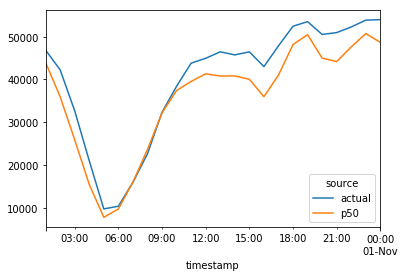

In [94]:
pivot_df.plot()

## Cleanup

The cells below will delete the items that were created one at a time until all items that were created have been removed.

In [105]:
# Delete the Foreacst:
forecast.delete_forecast(ForecastArn=forecast_arn)

{'ResponseMetadata': {'RequestId': '657e7457-ce46-4d5d-8768-0cc289898984',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Wed, 25 Dec 2019 07:03:10 GMT',
   'x-amzn-requestid': '657e7457-ce46-4d5d-8768-0cc289898984',
   'content-length': '0',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [109]:
# Delete the Predictor:
forecast.delete_predictor(PredictorArn=predictorArn)

{'ResponseMetadata': {'RequestId': '348019f0-fc66-4aa0-9676-759432384fd0',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Wed, 25 Dec 2019 07:06:17 GMT',
   'x-amzn-requestid': '348019f0-fc66-4aa0-9676-759432384fd0',
   'content-length': '0',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [110]:
# Delete Import
forecast.delete_dataset_import_job(DatasetImportJobArn=ds_import_job_arn)

NameError: name 'ds_import_job_arn' is not defined

In [107]:
# Delete the Dataset:
forecast.delete_dataset(DatasetArn=datasetArn)

NameError: name 'datasetArn' is not defined

In [104]:
# Delete the DatasetGroup:
forecast.delete_dataset_group(DatasetGroupArn=datasetGroupArn)

NameError: name 'datasetGroupArn' is not defined

## IAM Policy Cleanup

The very last step in the notebooks is to remove the policies that were attached to a role and then to delete it. No changes should need to be made here, just execute the cell.

In [ ]:
# IAM policies should also be removed
iam = boto3.client("iam")
iam.detach_role_policy(PolicyArn="arn:aws:iam::aws:policy/AmazonS3FullAccess", RoleName=role_name)
iam.detach_role_policy(PolicyArn="arn:aws:iam::aws:policy/AmazonForecastFullAccess",RoleName=role_name)

iam.delete_role(RoleName=role_name)